In [2]:
!pip install --no-cache-dir --force-reinstall onnx onnxruntime skl2onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 118.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 165.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 156.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 180.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 164.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 158.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 159.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 151.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import onnx
import onnxruntime
import skl2onnx

print("ONNX Version:", onnx.__version__)
print("ONNX Runtime Version:", onnxruntime.__version__)
print("SKL2ONNX Version:", skl2onnx.__version__)


ONNX Version: 1.17.0
ONNX Runtime Version: 1.21.0
SKL2ONNX Version: 1.18.0


Confusion Matrix:
 [[13  0  0]
 [ 0  6  0]
 [ 0  1 10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

Accuracy: 0.9666666666666667


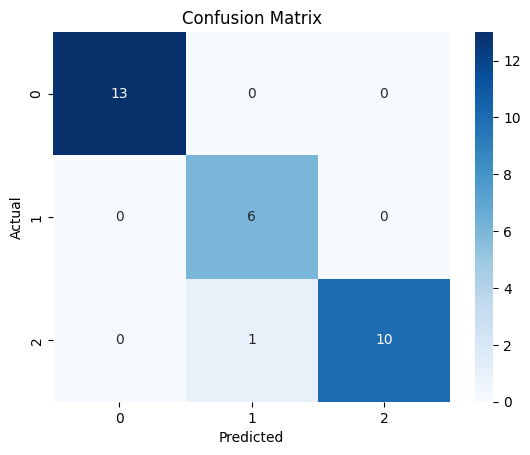

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Split data into training and test sets
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocess data: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [3]:
# ================================
# Convert Model to ONNX
# ================================
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define input type for ONNX conversion
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]

# Convert the trained model to ONNX format
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the model
onnx_model_path = "logistic_regression.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"ONNX model saved as {onnx_model_path}")

ONNX model saved as logistic_regression.onnx


In [5]:
# ================================
# Load & Run ONNX Model
# ================================
import onnxruntime as rt

# Load the ONNX model
session = rt.InferenceSession(onnx_model_path)

# Extract input name
input_name = session.get_inputs()[0].name

# Run prediction on test data
onnx_predictions = session.run(None, {input_name: X_test_scaled.astype(np.float32)})[0]

# Check if predictions are 1D or 2D
if len(onnx_predictions.shape) > 1:
    onnx_predictions = np.argmax(onnx_predictions, axis=1)  # Only apply if 2D

# Compare with sklearn predictions
print("ONNX Accuracy:", accuracy_score(y_test, onnx_predictions))


ONNX Accuracy: 0.9666666666666667
